# Quantum Neural Network Classification

## Setup

### Libraries Installation

In [42]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit-machine-learning[sparse]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Libraries Importation

In [43]:
import numpy as np
from typing import Union
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [44]:
from qiskit import Aer, QuantumCircuit

from qiskit.opflow import Z, I, StateFn

from qiskit.utils import QuantumInstance, algorithm_globals

from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

In [45]:
# set random seed
algorithm_globals.random_seed = 42

# we set shots to 10 as this will determine the number of samples later on
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots = 10)

## Classification

We prepare a simple classification dataset to illustrate the following algorithms

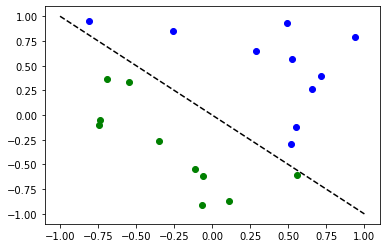

In [46]:
num_inputs = 2
num_samples = 20

X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)
y = 2 * y01 - 1
y_one_hot = np.zeros((num_samples, 2))

for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
        
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Classification with the an `OpflowQNN`

* The model is expected to return one-dimensional output in $[-1, +1]$.

* This only works for binary classification and we assign the two classes to $-1$ and $+1$.

In [47]:
# construct QNN
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

In [48]:
# QNN maps inputs to [-1, +1]
opflow_qnn.forward(X[0, :], algorithm_globals.random.random(opflow_qnn.num_weights))

array([[0.2]])

In [49]:
# callback function that draws a live plot when the fit method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [50]:
# construct neural network classifier
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=COBYLA(), callback=callback_graph)

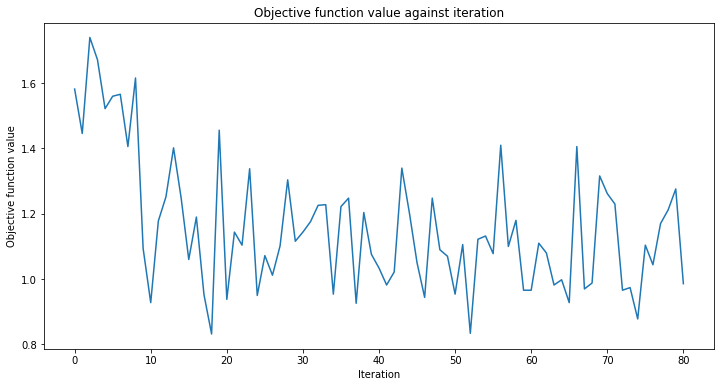

In [51]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [79]:
# score classifier
score = opflow_classifier.score(X, y) * 100
print("The classification score of OpflowQNN is:", int(score), "%")

The classification score of OpflowQNN is: 60 %


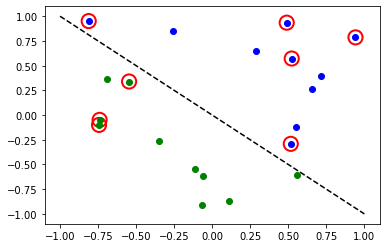

In [53]:
# evaluate data points
y_predict = opflow_classifier.predict(X)

# plot results (red if wrongly classified)
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
        
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Classification with a `CircuitQNN`

* The model is expected to return $d$-dimensional probability vector as output, where $d$ denotes the number of classes.

* Sampling from a Quantum Circuit results in a probability distribution, we just need to define a mapping from the measures to the classes.

* For binary classification we use the parity mapping.

In [54]:
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw()

┌──────────────────────────┐┌──────────────────────────────────────┐
q_0: ┤0                         ├┤0                                     ├
     │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
q_1: ┤1                         ├┤1                                     ├
     └──────────────────────────┘└──────────────────────────────────────┘

In [55]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2

# corresponds to the number of classes, possible outcomes of the (parity) mapping
output_shape = 2

In [56]:
# construct QNN
circuit_qnn = CircuitQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=quantum_instance,
)

In [57]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(
    neural_network=circuit_qnn, optimizer=COBYLA(), callback=callback_graph
)

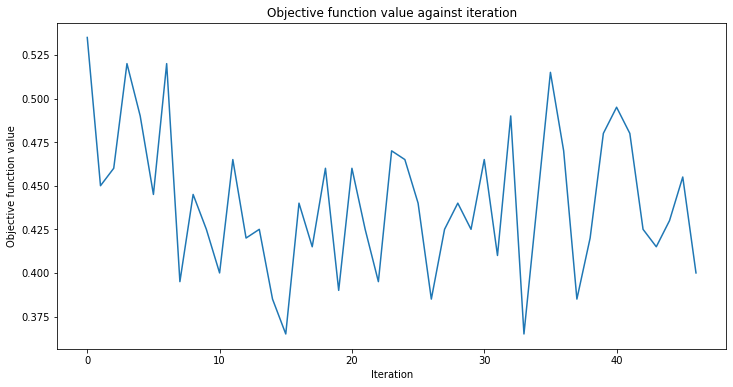

In [58]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
circuit_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [70]:
# score classifier
score = circuit_classifier.score(X, y01) * 100
print("The classification score of CircuitQNN is:", int(score), "%")

The classification score of CircuitQNN is: 70 %


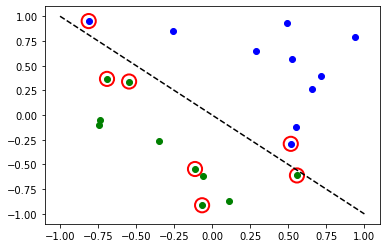

In [60]:
# evaluate data points
y_predict = circuit_classifier.predict(X)

# plot results (red if wrongly classified)
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)

plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Variational Quantum Classifier (`VQC`)

* The `VQC` is a special variant of the `NeuralNetworkClassifier` with a `CircuitQNN`.

* It applies a parity mapping which results in a probability vector, which is interpreted as a one-hot encoded result.

* By default, it applies the `CrossEntropyLoss` function that expects labels and will return predictions.

In [61]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

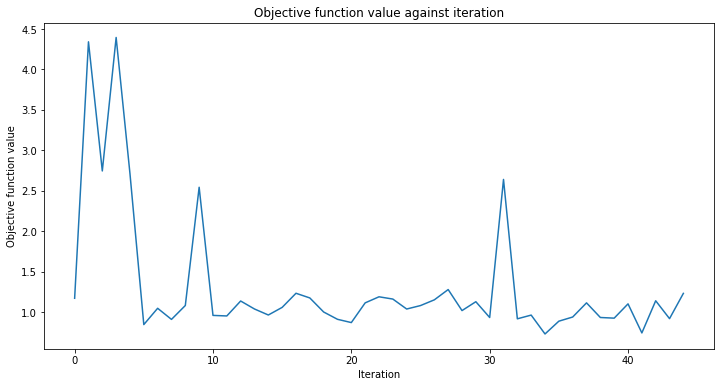

In [62]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [75]:
# score classifier
score = vqc.score(X, y_one_hot) * 100
print("The classification score of VQC is:", int(score), "%")

The classification score of VQC is: 75 %


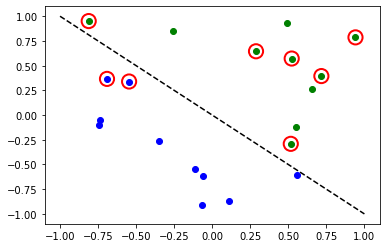

In [64]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results (red if wrongly classified)
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)

plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()